<a href="https://colab.research.google.com/github/Mihirirj/Audio_PRE-FE/blob/main/cnn_model_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import os
import sys
import pickle
import timeit
from tqdm import tqdm

# Audio Processing
import librosa
import librosa.display

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Keras / TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [10]:
try:
    from google.colab import drive
    print("Running in Google Colab. Mounting Drive and installing dependencies.")

    !apt-get update -qq && apt-get install -y libsndfile1 -qq

    drive.mount('/content/drive')

    CREMA_D_PATH = "/content/drive/MyDrive/AudioWAV/"
except ImportError:
    print("Not running in Google Colab. Assuming local environment.")

    CREMA_D_PATH = "./AudioWAV/"


Running in Google Colab. Mounting Drive and installing dependencies.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



--- Starting Data Loading ---


Parsing filenames: 100%|██████████| 7442/7442 [00:00<00:00, 490447.02it/s]


CREMA-D DataFrame created successfully.
Emotion Counts:
Emotions
fear       1271
disgust    1271
sad        1271
happy      1271
angry      1271
neutral    1087
Name: count, dtype: int64


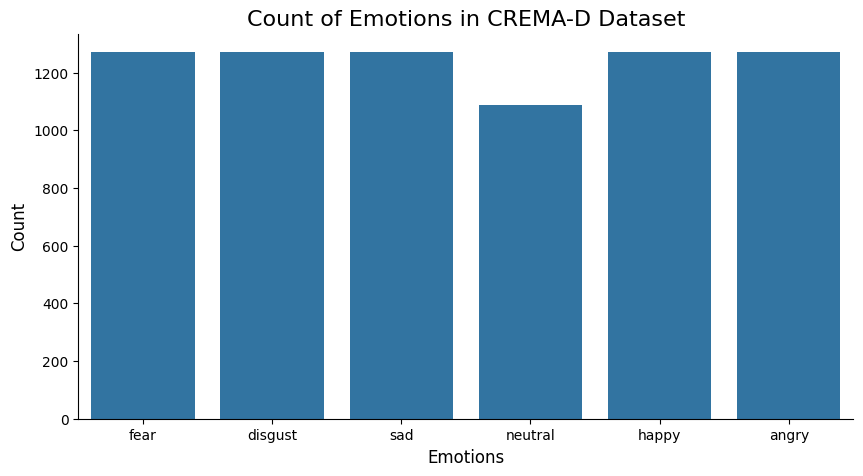

In [12]:
print("\n--- Starting Data Loading ---")
crema_directory_list = os.listdir(CREMA_D_PATH)

file_emotion = []
file_path = []

for file in tqdm(crema_directory_list, desc="Parsing filenames"):

    if file.endswith('.wav'):
        file_path.append(os.path.join(CREMA_D_PATH, file))

        part = file.split('_')
        emotion_code = part[2]

        if emotion_code == 'SAD':
            file_emotion.append('sad')
        elif emotion_code == 'ANG':
            file_emotion.append('angry')
        elif emotion_code == 'DIS':
            file_emotion.append('disgust')
        elif emotion_code == 'FEA':
            file_emotion.append('fear')
        elif emotion_code == 'HAP':
            file_emotion.append('happy')
        elif emotion_code == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')


emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)

print("\nCREMA-D DataFrame created successfully.")
print("Emotion Counts:")
print(data_path['Emotions'].value_counts())


plt.figure(figsize=(10, 5))
plt.title('Count of Emotions in CREMA-D Dataset', size=16)
sns.countplot(x=data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [13]:
def noise(data):

    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):

    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def stretch(data, rate=0.8):

    return librosa.effects.time_stretch(y=data, rate=rate)

def extract_features(data, sr=22050, n_mfcc=40):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T  # Transpose to have time steps as the first dimension

def get_features_with_augmentation(path):

    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    # 1. Original Features
    res1 = extract_features(data, sr)
    # 2. Noise-Augmented Features
    noise_data = noise(data)
    res2 = extract_features(noise_data, sr)
    # 3. Pitch-Augmented Features
    pitch_data = pitch(data, sr)
    res3 = extract_features(pitch_data, sr)
    # 4. Stretch-Augmented Features
    stretch_data = stretch(data)
    res4 = extract_features(stretch_data, sr)

    # Return a list of all feature sets
    return [res1, res2, res3, res4]

print("Functions for feature extraction and augmentation are defined.")


X_features, Y_labels = [], []
start_time = timeit.default_timer()

for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions), total=len(data_path), desc="Extracting Features"):
    try:

        feature_list = get_features_with_augmentation(path)
        for features in feature_list:
            X_features.append(features)
            Y_labels.append(emotion)
    except Exception as e:
        print(f"Error processing {path}: {e}")

stop_time = timeit.default_timer()
print(f'\nFeature extraction completed in: {stop_time - start_time:.2f}s')


max_len = max([len(x) for x in X_features])
print(f"Maximum sequence length found: {max_len}")

X_padded = pad_sequences(X_features, maxlen=max_len, padding='post', dtype='float32')


np.save('X_cnn_features.npy', X_padded)
np.save('Y_cnn_labels.npy', np.array(Y_labels))
with open('cnn_max_len.txt', 'w') as f:
    f.write(str(max_len))

print("\nPadded features and labels saved to '.npy' files.")
print("Max sequence length saved to 'cnn_max_len.txt'")

Functions for feature extraction and augmentation are defined.


Extracting Features: 100%|██████████| 7442/7442 [33:47<00:00,  3.67it/s]



Feature extraction completed in: 2027.67s
Maximum sequence length found: 135

Padded features and labels saved to '.npy' files.
Max sequence length saved to 'cnn_max_len.txt'


In [14]:
print("\n--- Splitting and Scaling Data ---")


X = np.load('X_cnn_features.npy')
Y = np.load('Y_cnn_labels.npy')

encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()


x_train, x_test, y_train, y_test = train_test_split(X, Y_encoded, random_state=42, test_size=0.2, shuffle=True)


scaler = StandardScaler()

x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_train_scaled_2d = scaler.fit_transform(x_train_2d)
x_train = x_train_scaled_2d.reshape(x_train.shape)


x_test_2d = x_test.reshape(x_test.shape[0], -1)
x_test_scaled_2d = scaler.transform(x_test_2d)
x_test = x_test_scaled_2d.reshape(x_test.shape)

print(f"Data shapes after splitting and scaling: \n"
      f"x_train: {x_train.shape}\n"
      f"y_train: {y_train.shape}\n"
      f"x_test: {x_test.shape}\n"
      f"y_test: {y_test.shape}")


--- Splitting and Scaling Data ---
Data shapes after splitting and scaling: 
x_train: (23814, 135, 40)
y_train: (23814, 6)
x_test: (5954, 135, 40)
y_test: (5954, 6)


In [15]:
print("\n--- Building the CNN Model ---")

input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = y_train.shape[1]

model = Sequential()


model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))


model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.3))


model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))


model.add(Flatten())
model.add(Dropout(0.3))


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())


model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


--- Building the CNN Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 135, 256)       │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 135, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 68, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 68, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 68, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 34, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1088)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1088)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       139,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,534 (1.46 MB)

 Trainable params: 381,382 (1.45 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [17]:
print("\n--- Starting Model Training ---")

# Define callbacks
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, lr_reduction, model_checkpoint]
)

print("\nModel training complete.")


--- Starting Model Training ---
Epoch 1/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 104s 278ms/step - accuracy: 0.9956 - loss: 0.0145 - val_accuracy: 0.8831 - val_loss: 0.5197 - learning_rate: 1.0000e-05
Epoch 2/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 131s 248ms/step - accuracy: 0.9950 - loss: 0.0161 - val_accuracy: 0.8844 - val_loss: 0.5101 - learning_rate: 1.0000e-05
Epoch 3/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 92s 246ms/step - accuracy: 0.9961 - loss: 0.0137 - val_accuracy: 0.8819 - val_loss: 0.5184 - learning_rate: 1.0000e-05
Epoch 4/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 246ms/step - accuracy: 0.9947 - loss: 0.0161 - val_accuracy: 0.8828 - val_loss: 0.5189 - learning_rate: 1.0000e-05
Epoch 5/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 148s 261ms/step - accuracy: 0.9946 - loss: 0.0151 - val_accuracy: 0.8821 - val_loss: 0.5209 - learning_rate: 1.0000e-05
Epoch 6/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 136s 245ms/step - accuracy: 0.9947 - loss: 0.0164 - val_accuracy: 0.8846 - val_loss: 0.5064 - learning_rate: 1.0000e-05
Ep


--- Evaluating Model Performance ---


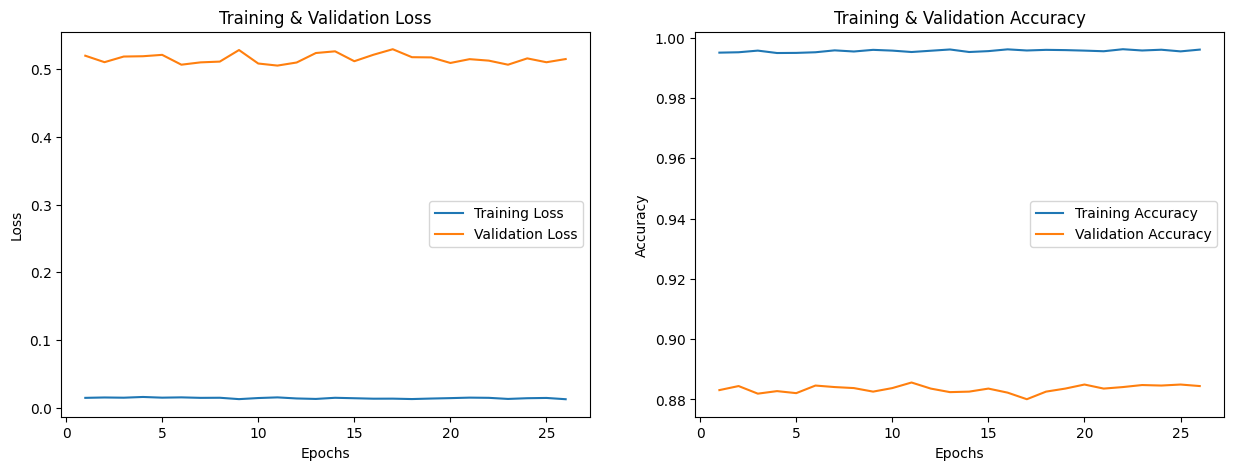


Final Model Evaluation on Test Data:
Test Accuracy: 88.56%
Test Loss: 0.5051

Generating and saving predictions for the CNN model...
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Successfully saved CNN model predictions to 'cnn_preds.npy'
Shape of the saved predictions: (5954, 6)

Classification Report:
              precision    recall  f1-score   support

       angry       0.98      0.91      0.94      1011
     disgust       0.88      0.87      0.87      1035
        fear       0.92      0.82      0.87      1016
       happy       0.94      0.87      0.90      1015
     neutral       0.84      0.93      0.88       837
         sad       0.79      0.94      0.86      1040

    accuracy                           0.89      5954
   macro avg       0.89      0.89      0.89      5954
weighted avg       0.89      0.89      0.89      5954



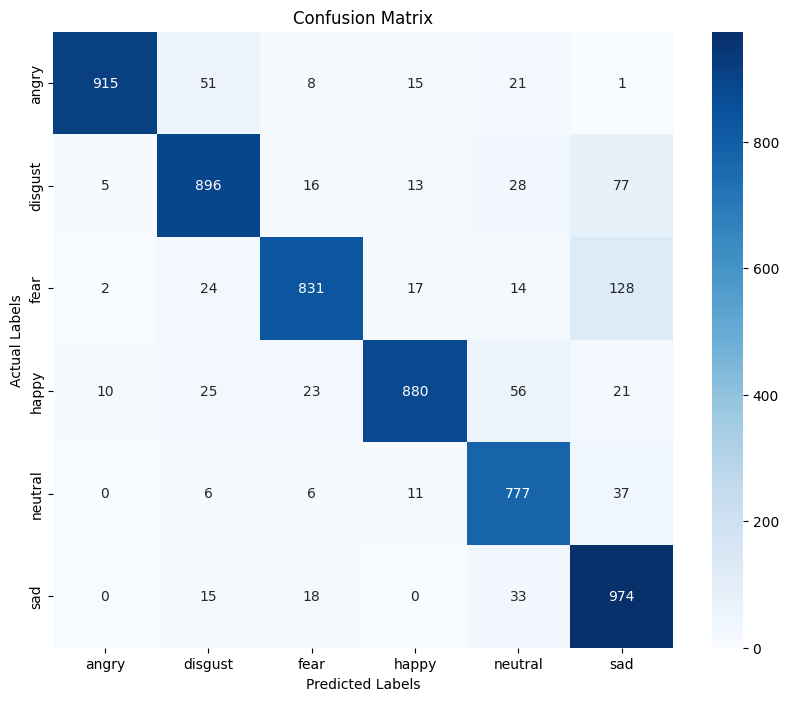


--- Example Predictions with Emotional Valence ---
Actual: angry      | Predicted: angry      | Valence: Negative
Actual: angry      | Predicted: angry      | Valence: Negative
Actual: sad        | Predicted: sad        | Valence: Negative
Actual: disgust    | Predicted: disgust    | Valence: Negative
Actual: fear       | Predicted: fear       | Valence: Negative
Actual: neutral    | Predicted: neutral    | Valence: Neutral
Actual: happy      | Predicted: happy      | Valence: Positive
Actual: happy      | Predicted: happy      | Valence: Positive
Actual: disgust    | Predicted: disgust    | Valence: Negative
Actual: sad        | Predicted: sad        | Valence: Negative


In [22]:

print("\n--- Evaluating Model Performance ---")

epochs = range(1, len(history.history['accuracy']) + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(epochs, history.history['loss'], label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()


print("\nFinal Model Evaluation on Test Data:")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


print("\nGenerating and saving predictions for the CNN model...")

cnn_preds = model.predict(x_test)

np.save("cnn_preds.npy", cnn_preds)
print("Successfully saved CNN model predictions to 'cnn_preds.npy'")
print("Shape of the saved predictions:", cnn_preds.shape)


y_pred_labels = encoder.inverse_transform(cnn_preds)
y_test_labels = encoder.inverse_transform(y_test)

print("\nClassification Report:")
class_names = encoder.categories_[0]
print(classification_report(y_test_labels, y_pred_labels, target_names=class_names))

cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

def get_valence(emotion):
    emotion = emotion.lower()
    if emotion == 'happy':
        return 'Positive'
    elif emotion in ['sad', 'angry', 'fear', 'disgust']:
        return 'Negative'
    else:
        return 'Neutral'

print("\n--- Example Predictions with Emotional Valence ---")
for i in range(10):
    actual_emotion = y_test_labels[i][0]
    predicted_emotion = y_pred_labels[i][0]
    valence = get_valence(predicted_emotion)
    print(f"Actual: {actual_emotion:<10} | Predicted: {predicted_emotion:<10} | Valence: {valence}")

In [23]:
print("\n--- Saving Final Model and Artifacts ---")


model_json = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved to cnn_model.json")
print("Best model weights were already saved to best_cnn_model.keras during training.")


with open('scaler_cnn.pickle', 'wb') as f:
    pickle.dump(scaler, f)
with open('encoder_cnn.pickle', 'wb') as f:
    pickle.dump(encoder, f)
print("Scaler saved to scaler_cnn.pickle")
print("Encoder saved to encoder_cnn.pickle")


--- Saving Final Model and Artifacts ---
Model architecture saved to cnn_model.json
Best model weights were already saved to best_cnn_model.keras during training.
Scaler saved to scaler_cnn.pickle
Encoder saved to encoder_cnn.pickle


In [24]:
def predict_emotion_from_file(audio_path):
    """
    Loads a single audio file, processes it, and predicts the emotion and valence
    using the trained CNN model.
    """
    try:

        with open('cnn_model.json', 'r') as json_file:
            loaded_model_json = json_file.read()
        loaded_model = model_from_json(loaded_model_json)


        loaded_model.load_weights("best_cnn_model.keras")


        with open('scaler_cnn.pickle', 'rb') as f:
            scaler = pickle.load(f)
        with open('encoder_cnn.pickle', 'rb') as f:
            encoder = pickle.load(f)
        with open('cnn_max_len.txt', 'r') as f:
            max_len = int(f.read())


        data, sr = librosa.load(audio_path, duration=2.5, offset=0.6)
        features = extract_features(data, sr, n_mfcc=40)


        padded_features = pad_sequences([features], maxlen=max_len, padding='post', dtype='float32')
        padded_features_2d = padded_features.reshape(1, -1)
        scaled_features_2d = scaler.transform(padded_features_2d)
        final_features = scaled_features_2d.reshape(padded_features.shape)

        prediction = loaded_model.predict(final_features, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_label = encoder.categories_[0][predicted_index]
        predicted_valence = get_valence(predicted_label)

        return predicted_label, predicted_valence

    except Exception as e:
        return f"Error during prediction: {e}", None


try:
    test_file_path = data_path.Path.sample(1).iloc[0]
    predicted_emotion, predicted_valence = predict_emotion_from_file(test_file_path)

    print(f"\n--- Prediction Test ---")
    print(f"File Path: {test_file_path}")
    print(f"Predicted Emotion: {predicted_emotion.upper()}")
    print(f"Predicted Valence: {predicted_valence.upper()}")

except Exception as e:
    print(f"\nCould not run prediction example. Error: {e}")


--- Prediction Test ---
File Path: /content/drive/MyDrive/AudioWAV/1081_IEO_SAD_LO.wav
Predicted Emotion: SAD
Predicted Valence: NEGATIVE


In [25]:

drive_save_path = "/content/drive/MyDrive/My_CNN_Speech_Model"

!mkdir -p "{drive_save_path}"

print(f"Ready to save files to: {drive_save_path}")

Ready to save files to: /content/drive/MyDrive/My_CNN_Speech_Model


In [26]:

source_file = "cnn_preds.npy"


destination_path = "/content/drive/MyDrive/My_CNN_Speech_Model/"


!cp "{source_file}" "{destination_path}"

print(f"Successfully copied '{source_file}' to your Google Drive!")

Successfully copied 'cnn_preds.npy' to your Google Drive!


In [27]:
!ls -lh "/content/drive/MyDrive/My_CNN_Speech_Model"

total 140K
-rw------- 1 root root 140K Aug  3 03:56 cnn_preds.npy
